### github.com/cheon4050

## Load packages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST train, test data set 가져오기

In [2]:
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## 대략적인 데이터 형태

mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


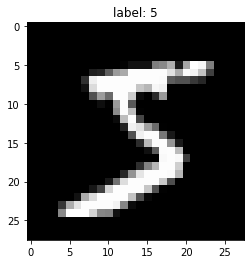

In [3]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

image, label = mnist_train.__getitem__(0)
print("image data 형태: ",image.size())
print("label: ", label)

img = image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()


## MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


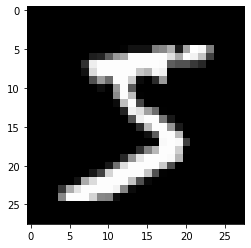

0


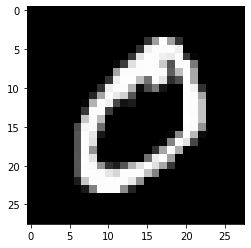

4


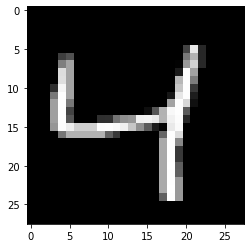

In [4]:
print(mnist_train[0][1])
print(mnist_train[0][0].size())

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

## convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


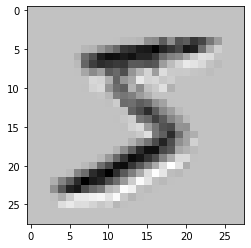

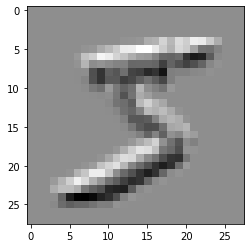

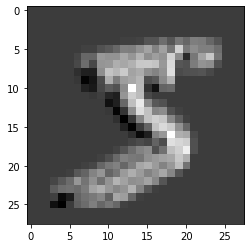

In [8]:
image, label=mnist_train[0]

image=image.view(-1, image.size()[0], image.size()[1],image.size()[2])
print(image.size())

print(label)

conv_layer = nn.Conv2d(in_channels=1, out_channels=3,kernel_size=3,padding=1)
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(),cmap='gray')
    plt.show()

# CNN 만들기

## train, test data 가져오기

In [11]:
import numpy as np
import torch.optim as optim
batch_size = 16
learning_rate = 0.0002
num_epoch = 10

In [12]:
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True)


## CNN 클래스 만들기 (모델 만들기)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(16,32,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out
    
model = CNN()

In [16]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [17]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## optimization

In [18]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = Variable(image)
        y_ = Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%50==0:
            print(loss,j,i)

tensor(2.3190, grad_fn=<NllLossBackward>) 0 0
tensor(1.6149, grad_fn=<NllLossBackward>) 50 0
tensor(0.4641, grad_fn=<NllLossBackward>) 0 1
tensor(0.8723, grad_fn=<NllLossBackward>) 50 1
tensor(0.0627, grad_fn=<NllLossBackward>) 0 2
tensor(0.6278, grad_fn=<NllLossBackward>) 50 2
tensor(0.6432, grad_fn=<NllLossBackward>) 0 3
tensor(0.3966, grad_fn=<NllLossBackward>) 50 3
tensor(0.0558, grad_fn=<NllLossBackward>) 0 4
tensor(0.6676, grad_fn=<NllLossBackward>) 50 4
tensor(0.1418, grad_fn=<NllLossBackward>) 0 5
tensor(0.0078, grad_fn=<NllLossBackward>) 50 5
tensor(0.0950, grad_fn=<NllLossBackward>) 0 6
tensor(0.2933, grad_fn=<NllLossBackward>) 50 6
tensor(0.0607, grad_fn=<NllLossBackward>) 0 7
tensor(0.0142, grad_fn=<NllLossBackward>) 50 7
tensor(0.0942, grad_fn=<NllLossBackward>) 0 8
tensor(0.2059, grad_fn=<NllLossBackward>) 50 8
tensor(0.0147, grad_fn=<NllLossBackward>) 0 9
tensor(0.0228, grad_fn=<NllLossBackward>) 50 9


In [19]:
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
try:
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [23]:
def ComputeAccr(dloader, imodel):
    correct = 0 
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs)
        label = Variable(labels)
        
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [24]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 95.31999969482422
